In [118]:
import numpy as np
import pandas as pd

In [119]:
Anaheim = pd.read_csv('Anaheim_reviews.csv')
LakeTahoe = pd.read_csv('LakeTahoe_reviews.csv')
LA = pd.read_csv('LA_reviews.csv')
Monterey = pd.read_csv('Monterey_reviews.csv')
Napa = pd.read_csv('Napa_reviews.csv')
PalmSprings = pd.read_csv('PalmSprings_reviews.csv')
SanDiego = pd.read_csv('SanDiego_reviews.csv')
SantaBarbara = pd.read_csv('SantaBarbara_reviews.csv')
SantaMonica = pd.read_csv('SantaMonica_reviews.csv')
SF = pd.read_csv('SF_reviews.csv')

In [120]:
merged = pd.concat([Anaheim, LakeTahoe, LA, Monterey, Napa, PalmSprings, SanDiego, SantaBarbara, SantaMonica, SF])

In [121]:
merged.isna().sum()

Destination_name             0
POI_name                     0
POI_reviews_count            0
POI_category                 0
POI_description           4941
POI_rating                   0
POI_address                  0
POI_Suggested_Duration    8427
POI_open_close_hours      8212
POI_reviews                  0
dtype: int64

### Sentiment Analysis

In [122]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [123]:
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [124]:
review_list = list(merged.POI_reviews)

In [125]:
sentiments = []
positive = []
negative = []
neutral = []
compound = []


for text in review_list:

  # Running Vader Analysis on each review
    com = analyser.polarity_scores(text)["compound"]
    pos = analyser.polarity_scores(text)["pos"]
    neu = analyser.polarity_scores(text)["neu"]
    neg = analyser.polarity_scores(text)["neg"]

  # Adding each value to the corresponding array
    positive.append(pos)
    negative.append(neg)
    neutral.append(neu)
    compound.append(com)
    sentiments.append({"Review":text,
                     "Positive": pos,
                     "Negative": neu,
                     "Neutral": neg,
                     "Compound": com})

sentiments_pd = pd.DataFrame.from_dict(sentiments)

In [126]:
sentiments_pd

,Review,Positive,Negative,Neutral,Compound
0,Disney California Adventure is an excellent ad...,0.179,0.821,0.000,0.8074
1,There were so many things wrong with this even...,0.000,0.941,0.059,-0.5209
2,Having to maneuver Disneyland California Adven...,0.160,0.840,0.000,0.7351
3,Buena Vista Street open only to stores and som...,0.160,0.840,0.000,0.6369
4,I went to Disneyland in January of 2020. Right...,0.201,0.799,0.000,0.6981
...,...,...,...,...,...
11184,I took the Filbert Steps up to Coit Tower. It ...,0.108,0.892,0.000,0.2828
11185,If you are into stair workouts this is for you...,0.095,0.905,0.000,0.7469
11186,A walk down the Filbert Steps is the perfect a...,0.070,0.930,0.000,0.5719
11187,We walked down the steps after visiting the Co...,0.191,0.809,0.000,0.9149


In [127]:
#Adding the sentiment analysis columns to the dataset.
merged["Positive"] = positive
merged["Negative"] = negative
merged["Neutral"] = neutral
merged["Compound"] = compound
merged["Review_Sentiment"] = ''

In [128]:
merged.loc[merged['Compound'] >= 0.05, 'Review_Sentiment'] = 'Positive'
merged.loc[merged['Compound'] <= -0.05, 'Review_Sentiment'] = 'Negative'

In [129]:
merged["Review_Sentiment"].replace('', 'Neutral', inplace = True)
merged = merged.drop(columns = ["Positive", "Negative", "Neutral", "Compound"])

<AxesSubplot:xlabel='Sentiment'>

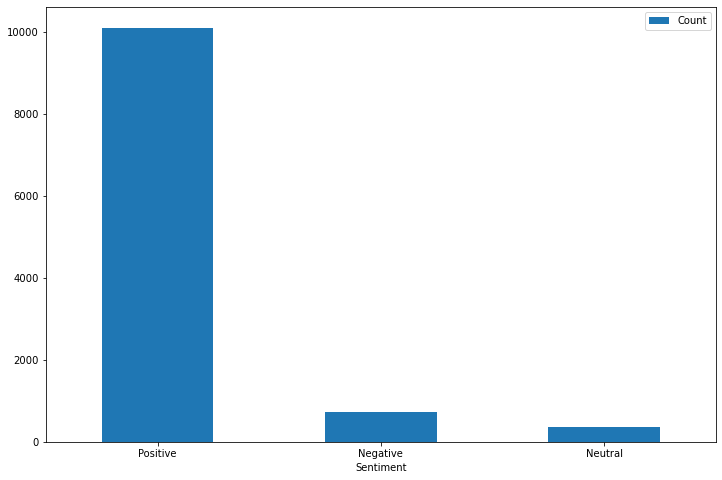

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the sentiment column unique value and their counts.
sentiment_values = merged['Review_Sentiment'].unique()

senti = pd.DataFrame({'Sentiment':sentiment_values, 'Count': merged['Review_Sentiment'].value_counts()})
senti.plot.bar(x='Sentiment', y='Count', rot=0, figsize=(12,8))

### Weighted-average calculation of reviews 

In [131]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [132]:
wavg(merged, "POI_rating", "POI_reviews_count")

4.429846545040302

In [133]:
merged.groupby(["POI_name"]).apply(wavg, "POI_rating", "POI_reviews_count")

POI_name
16 Avenue Tiled Steps                        4.500000
17-Mile Drive                                4.500000
26-Mile Bike Path                            4.500000
Abbot Kinney Boulevard                       4.403846
Adamm's Stained Glass & Art Glass Gallery    5.000000
                                               ...   
Yorba Regional Park                          4.500000
ZD Wines                                     4.500000
bG Gallery                                   5.000000
de Young Museum                              4.500000
di Rosa Center for Contemporary Art          4.500000
Length: 480, dtype: float64

In [134]:
merged_reviews_wavg = merged.groupby(["POI_name"],as_index=False).apply(wavg, "POI_rating", "POI_reviews_count")
merged_reviews_wavg = pd.DataFrame(merged_reviews_wavg)

In [135]:
merged_reviews_wavg.columns = [*merged_reviews_wavg.columns[:-1], 'Average_Rating']
merged_reviews_wavg

,POI_name,Average_Rating
0,16 Avenue Tiled Steps,4.500000
1,17-Mile Drive,4.500000
2,26-Mile Bike Path,4.500000
3,Abbot Kinney Boulevard,4.403846
4,Adamm's Stained Glass & Art Glass Gallery,5.000000
...,...,...
475,Yorba Regional Park,4.500000
476,ZD Wines,4.500000
477,bG Gallery,5.000000
478,de Young Museum,4.500000


In [136]:
merged = pd.merge(merged_reviews_wavg, merged, on='POI_name')
merged

,POI_name,Average_Rating,Destination_name,POI_reviews_count,POI_category,POI_description,POI_rating,POI_address,POI_Suggested_Duration,POI_open_close_hours,POI_reviews,Review_Sentiment
0,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,These tiled steps are an amazing sight to see....,Positive
1,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,These tiled steps are an amazing sight to see....,Positive
2,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,"These are beautiful steps, all the way up to a...",Positive
3,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,I was the only person here. It's off the beat...,Positive
4,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,"I enjoy these ""urban hikes"", but our pre-teen...",Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
11184,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,Di Rosa museum's just on the border of Napa (s...,Positive
11185,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,This is a very interesting stop in Napa that i...,Positive
11186,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,During this trip to Napa we wanted to do more ...,Negative
11187,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,"I enjoy all kinds of art, and found this colle...",Positive


In [137]:
merged.isna().sum()

POI_name                     0
Average_Rating               0
Destination_name             0
POI_reviews_count            0
POI_category                 0
POI_description           4941
POI_rating                   0
POI_address                  0
POI_Suggested_Duration    8427
POI_open_close_hours      8212
POI_reviews                  0
Review_Sentiment             0
dtype: int64

In [138]:
merged.to_csv(r'C:\Users\Anurag\Documents\TA_data\New data\All_Data\Preprocessed_data\final_merged.csv', index = False, header=True)

### Assigning trip-types

In [139]:
alldata = pd.read_csv(r'C:\Users\Anurag\Documents\TA_data\New data\All_Data\Preprocessed_data\final_merged.csv')

In [140]:
print(len(alldata['POI_category'].unique()))
alldata['POI_category'].unique()

108


array(['Points of Interest & Landmarks', 'Scenic Drives',
       'Biking Trails, Scenic Walking Areas\nOcean Park', 'Biking Trails',
       'Art Galleries', 'Theme Parks', 'Ski & Snowboard Areas', 'Canyons',
       'Parks', 'Historic Sites, National Parks',
       'Conference & Convention Centers', 'Wineries & Vineyards',
       'State Parks', 'Arenas & Stadiums', 'Specialty Museums',
       'Historic Sites', 'Rides & Activities', 'Visitor Centers',
       'Beaches', 'Theaters', 'History Museums', 'Monuments & Statues',
       'Military Museums', 'Character Experiences',
       'Natural History Museums', 'Amusement & Theme Parks',
       'Music Festivals', 'Architectural Buildings',
       'Beaches, Nature & Wildlife Areas', 'Shopping Malls',
       'Speciality Museums', 'Tramways', 'Hiking Trails',
       'Science Museums', 'Nature & Wildlife Areas', 'Antique Shops',
       'Art Museums', 'Historic Sites, Points of Interest & Landmarks',
       "Children's Museums", 'Caverns & Caves',

In [141]:
historic= ['Points of Interest & Landmarks', 'Art Galleries', 'Historic Sites, National Parks', 'Arenas & Stadiums',
       'Specialty Museums', 'Historic Sites', 'History Museums', 'Monuments & Statues', 'Military Museums',
       'Natural History Museums', 'Architectural Buildings', 'Speciality Museums', 'Science Museums',  'Antique Shops',
       'Art Museums', 'Historic Sites, Points of Interest & Landmarks', "Children's Museums", 'Speciality Museums, Science Museums',
        'Historic Walking Areas', 'Libraries', 'Historic Sites,  Landmarks', 'Observatories & Planetariums',
       'Specialty Museums, Historic Sites, Points of Interest & Landmarks', 'Points of Interest & Landmarks, Historic Walking Areas',
       'Points of Interest & Landmarks, Monuments & Statues', 'Historic Sites, Architectural Buildings', 'Churches & Cathedrals', 
        'Churches', "Speciality Museums, Children's Museums", 'Museums', 'Points of Interest & Landmarks, Architectural Buildings', 
        'Points of Interest & Landmarks, Churches & Cathedrals', 'Historic Sites, Points of Interest & Landmarks, Architectural Buildings', 
        'Natural History Museums, Aquariums', 'Civic Centers', 'Antique Stores', 'Points of Interest & Landmarks, Historic', 
       'Science Museums, Aquariums', 'Specialty Museums, History Museums', 'Historic Sites, Museums','Historic Walking Areas, Speciality Museums',
       'Historic Sites, Historic Walking Areas', 'Educational sites']

In [142]:
relaxed = ['Scenic Drives','Canyons','Parks','Wineries & Vineyards','State Parks','Beaches', 'Beaches, Nature & Wildlife Areas',
        'Tramways', 'Caverns & Caves', 'Mountains', 'Bridges', 'Beaches, Nature & Wildlife', 'Cemeteries', 'Neighborhoods',
        'State Parks, Points of Interest & Landmarks', 'Historic Sites, Neighborhoods', 'Waterfalls', 'Gardens','Bodies of Water',
        'Zoos', 'Aquarium', 'Observation Decks & Towers', 'Lighthouses', 'Parks, Ocean Park', 'Canyons, Deserts', 
         'Points of Interest & Landmarks, Scenic Walking Areas', 'Sacred & Religious Sites', 'Nature & Wildlife Areas, Gardens', 
         'Bodies of Water, Beaches','Mountains, National Parks', 'Farms','State Parks, Nature & Wildlife Areas']

In [143]:
adventurous = ['Biking Trails, Scenic Walking Areas\nOcean Park', 'Biking Trails', 'Theme Parks', 'Ski & Snowboard Areas', 
        'Rides & Activities', 'Amusement & Theme Parks', 'Hiking Trails', 'Nature & Wildlife Areas', 'Piers & Boardwalks',
        'Sports Camps & Clinics', 'Amusement & Theme Parks, Disney Parks & Activities', 'Disney Parks & Activities',
        'Points of Interest & Landmarks, Disney Parks & Activities', 'Nature & Wildlife Areas, Hiking Trails','Ranches', 
        'Sports Complexes', 'Playgrounds', 'Biking Trails, Nature & Wildlife Areas', 'Tramways, Ski & Snowboard Areas']

In [144]:
activities = ['Conference & Convention Centers','Visitor Centers', 'Theaters', 'Character Experiences', 'Music Festivals',
         'Shopping Malls','Factory Outlets','Flea & Street Markets', 'Farmers Markets', 'Distilleries', 'Movie Theaters',
        'Breweries', 'Shopping mall', 'Lookouts']

In [145]:
alldata

,POI_name,Average_Rating,Destination_name,POI_reviews_count,POI_category,POI_description,POI_rating,POI_address,POI_Suggested_Duration,POI_open_close_hours,POI_reviews,Review_Sentiment
0,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,These tiled steps are an amazing sight to see....,Positive
1,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,These tiled steps are an amazing sight to see....,Positive
2,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,"These are beautiful steps, all the way up to a...",Positive
3,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,I was the only person here. It's off the beat...,Positive
4,16 Avenue Tiled Steps,4.5,San Francisco,640,Points of Interest & Landmarks,16th AVENUE TILED STEPS IS LOCATED IN A RESIDE...,4.5,"16th Ave Just West Of Grand View Park, San Fra...",NaN,Hours\nSun\n10:00 AM - 5:00 PM\nMon - Sat\n9:3...,"I enjoy these ""urban hikes"", but our pre-teen...",Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
11184,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,Di Rosa museum's just on the border of Napa (s...,Positive
11185,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,This is a very interesting stop in Napa that i...,Positive
11186,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,During this trip to Napa we wanted to do more ...,Negative
11187,di Rosa Center for Contemporary Art,4.5,Napa,148,Art Museums,Located on 217 acres in the Carneros region of...,4.5,"5200 Sonoma Hwy, Napa, CA 94559-9761",Suggested Duration:2-3 hours,Hours\nSat - Sun\n11:00 AM - 3:00 PM,"I enjoy all kinds of art, and found this colle...",Positive


In [146]:
trip_type = []
for i in range(len(alldata["POI_category"])):
    if alldata["POI_category"][i] in historic:
        trip_type.append("Historic")
        
    elif alldata["POI_category"][i] in relaxed:
        trip_type.append("Relaxed")

    elif alldata["POI_category"][i] in adventurous:
        trip_type.append("Adventurous")

    elif alldata["POI_category"][i] in activities:
        trip_type.append("Activities")

In [147]:
alldata["Trip_type"] = trip_type

In [148]:
alldata["Trip_type"].value_counts()

Relaxed        4265
Historic       3891
Adventurous    1890
Activities     1143
Name: Trip_type, dtype: int64

In [149]:
alldata["Destination_name"].value_counts()

Los Angeles      1737
Napa             1471
Santa Barbara    1408
Santa Monica     1172
Anaheim          1022
San Diego        1021
Palm Springs     1004
Monterey          977
Lake Tahoe        776
San Francisco     601
Name: Destination_name, dtype: int64

In [158]:
alldata.groupby(["Destination_name"]).nunique()

,POI_name,Average_Rating,POI_reviews_count,POI_category,POI_description,POI_rating,POI_address,POI_Suggested_Duration,POI_open_close_hours,POI_reviews,Review_Sentiment,Trip_type
Destination_name,,,,,,,,,,,,
Anaheim,42,3,86,13,5,3,27,1,1,1021,3,4
Lake Tahoe,43,3,37,21,8,3,44,2,2,776,3,4
Los Angeles,59,6,59,33,44,4,59,4,20,1460,3,4
Monterey,43,3,37,30,20,3,50,3,4,977,3,4
Napa,59,4,56,11,43,4,59,3,22,1469,3,4
Palm Springs,44,2,38,25,23,2,40,2,6,1004,3,4
San Diego,42,3,42,26,25,3,40,3,8,1021,3,4
San Francisco,30,2,30,21,28,2,29,4,12,557,3,4
Santa Barbara,60,4,52,33,34,4,73,4,17,1407,3,4


In [ ]:
Anaheim, LakeTahoe, LA, Monterey, Napa, PalmSprings, SanDiego, SantaBarbara, SantaMonica, SF

In [159]:
Anaheim["POI_name"].nunique()

42

In [160]:
countTT = alldata[["POI_name", "Destination_name", "Trip_type"]]

In [164]:
countTT = countTT.drop_duplicates()

In [179]:
result = countTT.groupby(["Destination_name", "Trip_type"], as_index = False).size()

In [189]:
result = pd.DataFrame(result)

In [198]:
result

,Destination_name,Trip_type,size
0,Anaheim,Activities,2
1,Anaheim,Adventurous,34
2,Anaheim,Historic,4
3,Anaheim,Relaxed,2
4,Lake Tahoe,Activities,3
5,Lake Tahoe,Adventurous,12
6,Lake Tahoe,Historic,13
7,Lake Tahoe,Relaxed,15
8,Los Angeles,Activities,5
9,Los Angeles,Adventurous,2


In [205]:
result.loc[(result["Destination_name"] == "Los Angeles") & (result["Trip_type"] == "Activities"), "Count"].sum()

5

In [208]:
result.columns = ["Destination_name", "Trip_type", "Count"]
dest_cities = list(result["Destination_name"].unique())

In [279]:

def recc_city(trip_type_list):
    recc_city_df = (result.loc[(result["Trip_type"].isin(a))]).groupby(["Destination_name"]).sum().nlargest(3,"Count")
    return list(recc_city_df.index)
    

In [258]:
a = ["Activities", "Relaxed"]

In [259]:
a

['Activities', 'Relaxed']

In [231]:
result.loc[(result["Destination_name"] == "Los Angeles") & (result["Trip_type"].isin(a)), "Destination_name"].sum()

'Los AngelesLos Angeles'

In [222]:
result.loc[(result["Trip_type"].isin(a)), "Count"].sum()

231

In [254]:
result["Destination_name"]

0           Anaheim
1           Anaheim
2           Anaheim
3           Anaheim
4        Lake Tahoe
5        Lake Tahoe
6        Lake Tahoe
7        Lake Tahoe
8       Los Angeles
9       Los Angeles
10      Los Angeles
11      Los Angeles
12         Monterey
13         Monterey
14         Monterey
15         Monterey
16             Napa
17             Napa
18             Napa
19             Napa
20     Palm Springs
21     Palm Springs
22     Palm Springs
23     Palm Springs
24        San Diego
25        San Diego
26        San Diego
27        San Diego
28    San Francisco
29    San Francisco
30    San Francisco
31    San Francisco
32    Santa Barbara
33    Santa Barbara
34    Santa Barbara
35    Santa Barbara
36     Santa Monica
37     Santa Monica
38     Santa Monica
39     Santa Monica
Name: Destination_name, dtype: object

In [273]:
b = pd.DataFrame((result.loc[(result["Trip_type"].isin(a))]).groupby(["Destination_name"]).sum().nlargest(3,"Count"))

In [278]:
list(b.index)

['Napa', 'Santa Barbara', 'Santa Monica']

In [246]:
a.groupby(["Destination_name"]).sum().nlargest(3, "Count")

,Count
Destination_name,
Napa,56
Santa Barbara,36
Santa Monica,26


In [247]:
a.groupby(["Destination_name"]).sum()

,Count
Destination_name,
Anaheim,4
Lake Tahoe,18
Los Angeles,19
Monterey,21
Napa,56
Palm Springs,14
San Diego,25
San Francisco,12
Santa Barbara,36


In [288]:
result

,Destination_name,Trip_type,Count
0,Anaheim,Activities,2
1,Anaheim,Adventurous,34
2,Anaheim,Historic,4
3,Anaheim,Relaxed,2
4,Lake Tahoe,Activities,3
5,Lake Tahoe,Adventurous,12
6,Lake Tahoe,Historic,13
7,Lake Tahoe,Relaxed,15
8,Los Angeles,Activities,5
9,Los Angeles,Adventurous,2


In [282]:
nlp = ["Historic", "Relaxed"]

In [283]:
def recc_city(trip_type_list):
    recc_city_df = (result.loc[(result["Trip_type"].isin(trip_type_list))]).groupby(["Destination_name"]).sum().nlargest(3,"Count")
    return list(recc_city_df.index)

In [284]:
recc_city(nlp)

['Napa', 'Los Angeles', 'Santa Barbara']

In [286]:
alldata.isna().sum()

POI_name                     0
Average_Rating               0
Destination_name             0
POI_reviews_count            0
POI_category                 0
POI_description           4941
POI_rating                   0
POI_address                  0
POI_Suggested_Duration    8427
POI_open_close_hours      8212
POI_reviews                  0
Review_Sentiment             0
Trip_type                    0
dtype: int64

In [287]:
alldata.to_csv (r'C:\Users\Anurag\Documents\TA_data\New data\All_Data\Preprocessed_data\alldata.csv', index = False, header=True)

#### Exporting trip-type wise count dataset for every city. 

In [289]:
result.to_csv (r'C:\Users\Anurag\Documents\TA_data\New data\All_Data\Preprocessed_data\POI_TripTypes_count.csv', index = False, header=True)